# Predicción Demanda: Keras

In [587]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import to_categorical
import keras as K
import copy as cp

from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)

## 1. Carga de Datos

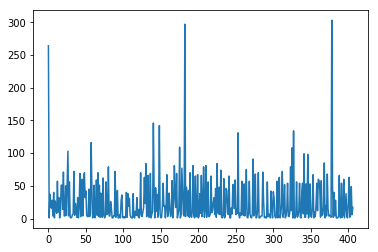

In [588]:
linea = '522'
tramo_horario = '4'
original_dataset = pd.read_csv('./datos/linea'+linea+'/data_linea'\
                               +linea+'_tramo'+tramo_horario+'.csv',sep=';')
plt.plot(original_dataset['nviajeros'])
plt.show()

## 2. Procesado de los Datos

### 2.1. Normalización de los Datos

In [589]:
eps = 1e-11

#Función para Normalizar la serie temporal
def transform(serie):
    return np.hstack(([np.NAN], np.log((serie[1:]+eps)/(serie[0:-1]+eps))))

#Función inversa a la normalización para deshacer la normalización
def inverse_transform(log_ratio, npasajeros_dia_anterior):
    return np.multiply(npasajeros_dia_anterior, np.exp(log_ratio))

In [590]:
#Conversión a array de cada una de las variables
npasajeros = np.array(original_dataset['nviajeros'])
lluvia = np.array(original_dataset['inten_lluvia'])
trafico = np.array(original_dataset['ocupacion_trafico'])
mes = np.array(original_dataset['mes'])
festivo = np.array(original_dataset['festivo'])
evento = np.array(original_dataset['intensidad_evento'])
semana = np.array(original_dataset['semana_mes'])
dia = np.array(original_dataset['day_of_week'])
ids_dias   = np.array(range(len(npasajeros)))

#Normalización de la serie de los pasajeros
logratio_pasajeros   = transform(npasajeros)

In [591]:
#Comprobación de los datos en las normalizaciones
print(npasajeros.shape)

print(ids_dias.shape)
print(logratio_pasajeros.shape)
print()
ndisp = 5
print("npasajeros[0:%d]:" % ndisp, npasajeros[0:ndisp])

print("ids_dias[0:%d]  :" % ndisp, ids_dias[0:ndisp])
print("logratio_pasajeros[0:%d]  :" % ndisp, logratio_pasajeros[0:ndisp])

(407,)
(407,)
(407,)

npasajeros[0:5]: [264   1  37  25  16]
ids_dias[0:5]  : [0 1 2 3 4]
logratio_pasajeros[0:5]  : [        nan -5.5759491   3.61091791 -0.39204209 -0.4462871 ]


In [592]:
print("\nComprobacion (deberian salir igual):")
print(inverse_transform(logratio_pasajeros[1:5], npasajeros[0:4]))
print(npasajeros[1:5])


Comprobacion (deberian salir igual):
[  1.  37.  25.  16.]
[ 1 37 25 16]


### 2.2. Creación del Dataset

In [593]:
#Función para convertir el dataset en un array
def create_dataset(serie,serie_lluvia,serie_trafico,serie_mes,serie_festivo,serie_evento,serie_semana,serie_day, lookback=1):
    n = np.shape(serie)[0]
    dataX = np.NAN * np.ones((n,lookback,8))
    dataY = cp.copy(serie)
    
    for i in range(n):
        a = max([0,i-lookback])
        dataX[i,(a+lookback-i):,0] = serie[a:i]
        dataX[i,(a+lookback-i):,1] = serie_lluvia[a:i]
        dataX[i,(a+lookback-i):,2] = serie_trafico[a:i]
        dataX[i,(a+lookback-i):,3] = serie_mes[(a+1):(i+1)]
        dataX[i,(a+lookback-i):,4] = serie_festivo[(a+1):(i+1)]
        dataX[i,(a+lookback-i):,5] = serie_evento[(a+1):(i+1)]
        dataX[i,(a+lookback-i):,6] = serie_semana[(a+1):(i+1)]
        dataX[i,(a+lookback-i):,7] = serie_day[(a+1):(i+1)]
    
    return dataX, dataY

In [594]:
lookback = 4

dataX_aux, dataY_aux = create_dataset(logratio_pasajeros, lluvia, trafico,
                                      mes, festivo, evento, semana, dia,
                                      lookback=lookback)

In [595]:
dataX_aux[0:100,:,:]

array([[[          nan,           nan,           nan, ...,           nan,
                   nan,           nan],
        [          nan,           nan,           nan, ...,           nan,
                   nan,           nan],
        [          nan,           nan,           nan, ...,           nan,
                   nan,           nan],
        [          nan,           nan,           nan, ...,           nan,
                   nan,           nan]],

       [[          nan,           nan,           nan, ...,           nan,
                   nan,           nan],
        [          nan,           nan,           nan, ...,           nan,
                   nan,           nan],
        [          nan,           nan,           nan, ...,           nan,
                   nan,           nan],
        [          nan,    0.        ,    0.        , ...,    0.        ,
            0.        ,    4.        ]],

       [[          nan,           nan,           nan, ...,           nan,
          

### 2.3. Conversión de las Categóricas

In [596]:
aa = dataX_aux[30:35,:,3]
print(aa)
print(aa.shape)
print()
bb = to_categorical(aa.flatten())
bc = bb.reshape(aa.shape[0],aa.shape[1],bb.shape[1])
print(bc)
print(bc.shape)

print(dataX_aux[10:12,:,0:3])
print(np.concatenate((dataX_aux[10:12,:,0:3], dataX_aux[11:13,:,0:3]),axis=2))

[[ 3.  3.  3.  3.]
 [ 3.  3.  3.  3.]
 [ 3.  3.  3.  3.]
 [ 3.  3.  3.  3.]
 [ 3.  3.  3.  3.]]
(5, 4)

[[[ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]]

 [[ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]
  [ 0.  0.  0.  1.]]]
(5, 4, 4)
[[[ -1.94591015   0.           0.        ]
  [  2.30258509   0.          55.        ]
  [ -3.68887945   0.           0.        ]
  [  3.29583687   0.          23.        ]]

 [[  2.30258509   0.          55.        ]
  [ -3.68887945   0.           0.        ]
  [  3.29583687   0.          23.        ]
  [ -0.65677954   0.           5.        ]]]
[[[ -1.94591015   0.           0.           2.30258509   0.          55.        ]
  [  2.30258509   0.          55.          -3.

In [597]:
print("dataX_aux.shape:", dataX_aux.shape)
print("dataY_aux.shape:", dataY_aux.shape)

dataX_aux.shape: (407, 4, 8)
dataY_aux.shape: (407,)


In [598]:
aux1 = dataX_aux[lookback:,:,3]-1
aux2 = to_categorical(aux1.flatten())
mes_one_hot = np.reshape(aux2, (aux1.shape[0], aux1.shape[1], aux2.shape[1]))
mes_one_hot = np.vstack((np.nan*cp.copy(mes_one_hot[0:lookback]), cp.copy(mes_one_hot)))
print(mes_one_hot.shape)
#print(mes_one_hot[0:7], "\n\n", "mes_one_hot.shape:", mes_one_hot.shape)

(407, 4, 12)


In [599]:
aux1 = dataX_aux[lookback:,:,6]
aux2 = to_categorical(aux1.flatten())
semana_one_hot = np.reshape(aux2, (aux1.shape[0], aux1.shape[1], aux2.shape[1]))
semana_one_hot = np.vstack((np.nan*cp.copy(semana_one_hot[0:lookback]), cp.copy(semana_one_hot)))
print(semana_one_hot.shape)
#print(semana_one_hot[0:7], "\n\n", "semana_one_hot.shape:", semana_one_hot.shape)

(407, 4, 3)


In [600]:
dataX_aux[0:10,:,7]

array([[ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,   4.],
       [ nan,  nan,   4.,   5.],
       [ nan,   4.,   5.,   0.],
       [  4.,   5.,   0.,   5.],
       [  5.,   0.,   5.,   6.],
       [  0.,   5.,   6.,   4.],
       [  5.,   6.,   4.,   5.],
       [  6.,   4.,   5.,   4.],
       [  4.,   5.,   4.,   5.]])

In [601]:
aux1 = dataX_aux[lookback:,:,7]
aux2 = to_categorical(aux1.flatten())
dia_one_hot = np.reshape(aux2, (aux1.shape[0], aux1.shape[1], aux2.shape[1]))
dia_one_hot = np.vstack((np.nan*cp.copy(dia_one_hot[0:lookback]), cp.copy(dia_one_hot)))
print(dia_one_hot.shape)
#print(dia_one_hot[0:10], "\n\n", "dia_one_hot.shape:", dia_one_hot.shape)

(407, 4, 7)


In [602]:
dataX = np.concatenate((dataX_aux[:,:,0:3], mes_one_hot, dataX_aux[:,:,4:6], semana_one_hot, dia_one_hot),axis=2)
dataY = dataY_aux

In [603]:
# Las siguientes lineas ya no valen:

semana_one_hot = to_categorical(dataX_aux[lookback:,:,6])
semana_one_hot = np.vstack((np.nan*cp.copy(semana_one_hot[0:lookback]), cp.copy(semana_one_hot)))
print(semana_one_hot[0:10])

dia_one_hot = to_categorical(dataX_aux[lookback:,:,7])
dia_one_hot = np.vstack((np.nan*cp.copy(dia_one_hot[0:lookback]), cp.copy(dia_one_hot)))
print(dia_one_hot[0:10])

print(dataX_aux[:,:,0:3].shape)
print(mes_one_hot.shape)
print(dataX_aux[:,:,4:6].shape)
print(semana_one_hot.shape)
print(dia_one_hot.shape)

[[ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]
 [  1.   0.   0.]
 [  1.   0.   0.]
 [  1.   0.   0.]
 [  0.   1.   0.]
 [  1.   0.   0.]
 [  1.   0.   0.]]
[[ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [  0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.]
 [  1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   1.   0.]
 [  1.   0.   0.   0.   0.   0.   0.]]
(407, 4, 3)
(407, 4, 12)
(407, 4, 2)
(1616, 3)
(1616, 7)


In [604]:
ndisp = 5
print("dataX.shape:", dataX.shape)
print("dataY.shape:", dataY.shape)
print()
print("logratio[0:%d]:" % ndisp, logratio_pasajeros[0:ndisp])
print("dataY[0:%d]   :" % ndisp, dataY[0:ndisp])
print()
print("dataX[0:%d]   :\n" % ndisp, dataX[0:ndisp])

dataX.shape: (407, 4, 27)
dataY.shape: (407,)

logratio[0:5]: [        nan -5.5759491   3.61091791 -0.39204209 -0.4462871 ]
dataY[0:5]   : [        nan -5.5759491   3.61091791 -0.39204209 -0.4462871 ]

dataX[0:5]   :
 [[[        nan         nan         nan         nan         nan         nan
           nan         nan         nan         nan         nan         nan
           nan         nan         nan         nan         nan         nan
           nan         nan         nan         nan         nan         nan
           nan         nan         nan]
  [        nan         nan         nan         nan         nan         nan
           nan         nan         nan         nan         nan         nan
           nan         nan         nan         nan         nan         nan
           nan         nan         nan         nan         nan         nan
           nan         nan         nan]
  [        nan         nan         nan         nan         nan         nan
           nan         nan 

In [605]:
if True:
    m=20
    print("Dias %d a %d:\n" % (0,m-1))
    print('npasajeros:         ', npasajeros[0:m])
    print('lluvia:             ', np.array2string(lluvia[0:m], formatter={'float_kind':'{0:.1f}'.format}))
    print('trafico:            ', np.array2string(trafico[0:m], formatter={'float_kind':'{0:.2f}'.format}))
    print('mes:                ', mes[0:m])
    print('festivo:            ', festivo[0:m])
    print('evento:             ', evento[0:m])
    print('semana:             ', semana[0:m])
    print('dia:                ', dia[0:m])
    print('ids_dias:           ', ids_dias[0:m])
    print('logratio_pasajeros: ', np.array2string(logratio_pasajeros[0:m], formatter={'float_kind':'{0:.2f}'.format}))

Dias 0 a 19:

npasajeros:          [264   1  37  25  16  28   4  40   1  27  14   8  57  10  32   1  10  51
  51  14]
lluvia:              [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.1 0.0]
trafico:             [0.00 0.00 0.00 0.00 0.00 0.00 0.00 55.00 0.00 23.00 5.00 1.00 3.60 0.00
 70.20 5.00 3.00 120.67 31.60 1.00]
mes:                 [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
festivo:             [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
evento:              [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
semana:              [0 0 0 0 1 1 1 1 2 2 2 2 2 0 0 1 1 1 1 2]
dia:                 [3 4 5 0 5 6 4 5 4 5 6 4 5 4 5 6 4 5 5 4]
ids_dias:            [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
logratio_pasajeros:  [nan -5.58 3.61 -0.39 -0.45 0.56 -1.95 2.30 -3.69 3.30 -0.66 -0.56 1.96
 -1.74 1.16 -3.47 2.30 1.63 0.00 -1.29]


In [606]:
for i in np.arange(m-4,m):
    print("* Dia %d:" % i)
    print()
    print('  dataX: ', np.array2string(dataX[i], formatter={'float_kind':'{0:.2f}'.format}))
    print()
    print("  dataY: %.2f" % dataY[i])
    print()

#print("Dias %d a %d:\n" % (0,m-1))
#print('dataY: ', np.array2string(dataY[m-4:m], formatter={'float_kind':'{0:.2f}'.format}))

* Dia 16:

  dataX:  [[1.96 0.00 3.60 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
 [-1.74 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00]
 [1.16 0.00 70.20 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
 [-3.47 0.00 5.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]]

  dataY: 2.30

* Dia 17:

  dataX:  [[-1.74 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00]
 [1.16 0.00 70.20 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00]
 [-3.47 0.00 5.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 0.00 1

In [607]:
# split into train and test sets
train_size = int(len(dataX) * 0.80)
test_size = len(dataX) - train_size
print("train size:", train_size, "\ntest_size:", test_size)

trainX           = dataX[(lookback+1):train_size] # lookback+1: para quitar todos los días que 
trainY           = dataY[(lookback+1):train_size] #             tienen alguna info con NAN

# las siguientes tres cantidades no las uso para entrenar, las usaremos después:
train_ids_dias   = ids_dias[(lookback+1):train_size]
train_npasajeros = npasajeros[(lookback+1):train_size]
train_npasajeros_dia_anterior = npasajeros[lookback:(train_size-1)]

testX            = dataX[train_size:]
testY            = dataY[train_size:]
test_ids_dias    = ids_dias[train_size:]
test_npasajeros  = npasajeros[train_size:]
test_npasajeros_dia_anterior = npasajeros[(train_size-1):-1]

print("\nNota: de esos %d se quitan los %d primeros por tener NaNs" % (train_size,lookback+1))
print("train size final:", trainX.shape)

train size: 325 
test_size: 82

Nota: de esos 325 se quitan los 5 primeros por tener NaNs
train size final: (320, 4, 27)


In [608]:
len(trainX)

320

In [609]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
print()
print(trainX[0:(lookback+1)])
print(trainY[0:(lookback+1)])

(320, 4, 27)
(320,)
(82, 4, 27)
(82,)

[[[ -5.5759491    0.           0.           1.           0.           0.
     0.           0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.           1.
     0.           0.           0.           0.           0.           0.
     0.           1.           0.        ]
  [  3.61091791   0.           0.           1.           0.           0.
     0.           0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.           1.
     0.           0.           1.           0.           0.           0.
     0.           0.           0.        ]
  [ -0.39204209   0.           0.           1.           0.           0.
     0.           0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.           0.
     1.           0.           0.           0.           0.           0.

## 3. Creación del Modelo

In [610]:
# create the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape=(lookback, trainX.shape[2]), kernel_regularizer='l1'))
#model.add(LSTM(5, input_shape=(lookback, trainX.shape[2])))
model.add(Dense(1,kernel_regularizer='l1'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [611]:
# fit the LSTM network
history = model.fit(trainX, trainY, validation_split=0.25, epochs=1000, batch_size=64, verbose=2)

Train on 240 samples, validate on 80 samples
Epoch 1/1000
0s - loss: 7.0058 - val_loss: 6.5213
Epoch 2/1000
0s - loss: 6.8651 - val_loss: 6.3793
Epoch 3/1000
0s - loss: 6.7192 - val_loss: 6.2504
Epoch 4/1000
0s - loss: 6.5840 - val_loss: 6.1328
Epoch 5/1000
0s - loss: 6.4658 - val_loss: 6.0247
Epoch 6/1000
0s - loss: 6.3480 - val_loss: 5.9288
Epoch 7/1000
0s - loss: 6.2532 - val_loss: 5.8413
Epoch 8/1000
0s - loss: 6.1610 - val_loss: 5.7602
Epoch 9/1000
0s - loss: 6.0867 - val_loss: 5.6827
Epoch 10/1000
0s - loss: 6.0095 - val_loss: 5.6097
Epoch 11/1000
0s - loss: 5.9311 - val_loss: 5.5424
Epoch 12/1000
0s - loss: 5.8625 - val_loss: 5.4762
Epoch 13/1000
0s - loss: 5.7893 - val_loss: 5.4110
Epoch 14/1000
0s - loss: 5.7222 - val_loss: 5.3440
Epoch 15/1000
0s - loss: 5.6538 - val_loss: 5.2791
Epoch 16/1000
0s - loss: 5.5895 - val_loss: 5.2145
Epoch 17/1000
0s - loss: 5.5244 - val_loss: 5.1522
Epoch 18/1000
0s - loss: 5.4572 - val_loss: 5.0930
Epoch 19/1000
0s - loss: 5.3926 - val_loss: 5.

0s - loss: 1.2846 - val_loss: 1.6716
Epoch 164/1000
0s - loss: 1.2749 - val_loss: 1.6854
Epoch 165/1000
0s - loss: 1.2711 - val_loss: 1.6801
Epoch 166/1000
0s - loss: 1.2625 - val_loss: 1.6780
Epoch 167/1000
0s - loss: 1.2592 - val_loss: 1.6809
Epoch 168/1000
0s - loss: 1.2540 - val_loss: 1.6835
Epoch 169/1000
0s - loss: 1.2560 - val_loss: 1.6843
Epoch 170/1000
0s - loss: 1.2545 - val_loss: 1.6677
Epoch 171/1000
0s - loss: 1.2482 - val_loss: 1.6807
Epoch 172/1000
0s - loss: 1.2398 - val_loss: 1.6906
Epoch 173/1000
0s - loss: 1.2334 - val_loss: 1.6943
Epoch 174/1000
0s - loss: 1.2297 - val_loss: 1.6853
Epoch 175/1000
0s - loss: 1.2144 - val_loss: 1.6802
Epoch 176/1000
0s - loss: 1.2202 - val_loss: 1.6859
Epoch 177/1000
0s - loss: 1.2044 - val_loss: 1.6839
Epoch 178/1000
0s - loss: 1.2040 - val_loss: 1.6775
Epoch 179/1000
0s - loss: 1.1982 - val_loss: 1.6759
Epoch 180/1000
0s - loss: 1.1888 - val_loss: 1.6869
Epoch 181/1000
0s - loss: 1.1923 - val_loss: 1.6861
Epoch 182/1000
0s - loss: 1

0s - loss: 0.8088 - val_loss: 1.7249
Epoch 331/1000
0s - loss: 0.8211 - val_loss: 1.7337
Epoch 332/1000
0s - loss: 0.8111 - val_loss: 1.7202
Epoch 333/1000
0s - loss: 0.8144 - val_loss: 1.7275
Epoch 334/1000
0s - loss: 0.8103 - val_loss: 1.7340
Epoch 335/1000
0s - loss: 0.8016 - val_loss: 1.7242
Epoch 336/1000
0s - loss: 0.8081 - val_loss: 1.7307
Epoch 337/1000
0s - loss: 0.7978 - val_loss: 1.7334
Epoch 338/1000
0s - loss: 0.8035 - val_loss: 1.7295
Epoch 339/1000
0s - loss: 0.7976 - val_loss: 1.7413
Epoch 340/1000
0s - loss: 0.8034 - val_loss: 1.7551
Epoch 341/1000
0s - loss: 0.7957 - val_loss: 1.7331
Epoch 342/1000
0s - loss: 0.7968 - val_loss: 1.7300
Epoch 343/1000
0s - loss: 0.7950 - val_loss: 1.7502
Epoch 344/1000
0s - loss: 0.7902 - val_loss: 1.7574
Epoch 345/1000
0s - loss: 0.7902 - val_loss: 1.7566
Epoch 346/1000
0s - loss: 0.7861 - val_loss: 1.7335
Epoch 347/1000
0s - loss: 0.7928 - val_loss: 1.7373
Epoch 348/1000
0s - loss: 0.7814 - val_loss: 1.7617
Epoch 349/1000
0s - loss: 0

0s - loss: 0.5904 - val_loss: 2.0369
Epoch 498/1000
0s - loss: 0.5987 - val_loss: 2.0134
Epoch 499/1000
0s - loss: 0.5852 - val_loss: 2.0219
Epoch 500/1000
0s - loss: 0.5916 - val_loss: 2.0250
Epoch 501/1000
0s - loss: 0.5922 - val_loss: 2.0408
Epoch 502/1000
0s - loss: 0.5963 - val_loss: 2.0368
Epoch 503/1000
0s - loss: 0.5830 - val_loss: 2.0090
Epoch 504/1000
0s - loss: 0.5897 - val_loss: 2.0240
Epoch 505/1000
0s - loss: 0.5924 - val_loss: 2.0341
Epoch 506/1000
0s - loss: 0.5691 - val_loss: 2.0344
Epoch 507/1000
0s - loss: 0.5876 - val_loss: 2.0446
Epoch 508/1000
0s - loss: 0.5747 - val_loss: 2.0619
Epoch 509/1000
0s - loss: 0.5754 - val_loss: 2.0272
Epoch 510/1000
0s - loss: 0.5871 - val_loss: 2.0229
Epoch 511/1000
0s - loss: 0.5675 - val_loss: 2.0721
Epoch 512/1000
0s - loss: 0.5719 - val_loss: 2.0449
Epoch 513/1000
0s - loss: 0.5684 - val_loss: 2.0289
Epoch 514/1000
0s - loss: 0.5645 - val_loss: 2.0475
Epoch 515/1000
0s - loss: 0.5757 - val_loss: 2.0607
Epoch 516/1000
0s - loss: 0

0s - loss: 0.4551 - val_loss: 2.3227
Epoch 661/1000
0s - loss: 0.4561 - val_loss: 2.3205
Epoch 662/1000
0s - loss: 0.4558 - val_loss: 2.3161
Epoch 663/1000
0s - loss: 0.4535 - val_loss: 2.3212
Epoch 664/1000
0s - loss: 0.4507 - val_loss: 2.3192
Epoch 665/1000
0s - loss: 0.4546 - val_loss: 2.3348
Epoch 666/1000
0s - loss: 0.4553 - val_loss: 2.3323
Epoch 667/1000
0s - loss: 0.4508 - val_loss: 2.3420
Epoch 668/1000
0s - loss: 0.4492 - val_loss: 2.3316
Epoch 669/1000
0s - loss: 0.4510 - val_loss: 2.3256
Epoch 670/1000
0s - loss: 0.4537 - val_loss: 2.3349
Epoch 671/1000
0s - loss: 0.4484 - val_loss: 2.3286
Epoch 672/1000
0s - loss: 0.4495 - val_loss: 2.3403
Epoch 673/1000
0s - loss: 0.4493 - val_loss: 2.3214
Epoch 674/1000
0s - loss: 0.4490 - val_loss: 2.3426
Epoch 675/1000
0s - loss: 0.4496 - val_loss: 2.3422
Epoch 676/1000
0s - loss: 0.4468 - val_loss: 2.3354
Epoch 677/1000
0s - loss: 0.4472 - val_loss: 2.3619
Epoch 678/1000
0s - loss: 0.4453 - val_loss: 2.3347
Epoch 679/1000
0s - loss: 0

0s - loss: 0.3805 - val_loss: 2.4042
Epoch 826/1000
0s - loss: 0.3779 - val_loss: 2.3866
Epoch 827/1000
0s - loss: 0.3788 - val_loss: 2.4058
Epoch 828/1000
0s - loss: 0.3810 - val_loss: 2.4239
Epoch 829/1000
0s - loss: 0.3767 - val_loss: 2.4083
Epoch 830/1000
0s - loss: 0.3756 - val_loss: 2.4137
Epoch 831/1000
0s - loss: 0.3769 - val_loss: 2.4185
Epoch 832/1000
0s - loss: 0.3776 - val_loss: 2.4197
Epoch 833/1000
0s - loss: 0.3787 - val_loss: 2.4389
Epoch 834/1000
0s - loss: 0.3791 - val_loss: 2.4026
Epoch 835/1000
0s - loss: 0.3769 - val_loss: 2.4149
Epoch 836/1000
0s - loss: 0.3787 - val_loss: 2.4166
Epoch 837/1000
0s - loss: 0.3764 - val_loss: 2.4092
Epoch 838/1000
0s - loss: 0.3738 - val_loss: 2.4391
Epoch 839/1000
0s - loss: 0.3754 - val_loss: 2.4175
Epoch 840/1000
0s - loss: 0.3729 - val_loss: 2.4180
Epoch 841/1000
0s - loss: 0.3767 - val_loss: 2.4156
Epoch 842/1000
0s - loss: 0.3737 - val_loss: 2.4307
Epoch 843/1000
0s - loss: 0.3707 - val_loss: 2.4136
Epoch 844/1000
0s - loss: 0

0s - loss: 0.3992 - val_loss: 2.3690
Epoch 992/1000
0s - loss: 0.3765 - val_loss: 2.5240
Epoch 993/1000
0s - loss: 0.3820 - val_loss: 2.3988
Epoch 994/1000
0s - loss: 0.3563 - val_loss: 2.3738
Epoch 995/1000
0s - loss: 0.3509 - val_loss: 2.4847
Epoch 996/1000
0s - loss: 0.3519 - val_loss: 2.3813
Epoch 997/1000
0s - loss: 0.3495 - val_loss: 2.4006
Epoch 998/1000
0s - loss: 0.3386 - val_loss: 2.4368
Epoch 999/1000
0s - loss: 0.3311 - val_loss: 2.4056
Epoch 1000/1000
0s - loss: 0.3294 - val_loss: 2.4396


## 4. Evaluación del Modelo

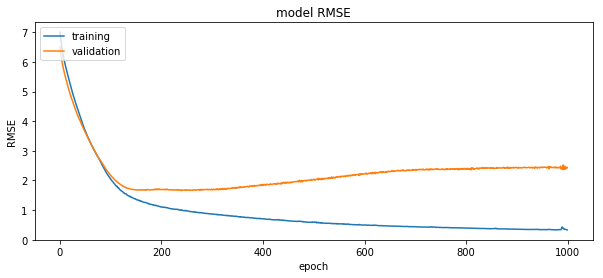

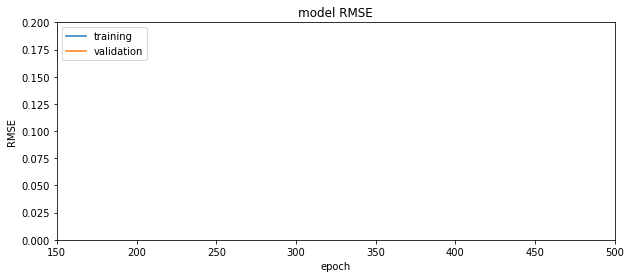

In [612]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.axis([150,500,0,0.2])
plt.show()


In [613]:
trainY_prediction = model.predict(trainX).flatten()
testY_prediction = model.predict(testX).flatten()

print(testY[0:ndisp])
print(testY_prediction[0:ndisp])

[ 2.19722458 -4.68213123  4.8978398  -4.8978398   0.        ]
[ 2.59472013 -2.43653083  1.42391598 -2.51040006  1.37708497]


In [614]:
train_npasajeros_prediction = inverse_transform(trainY_prediction,
                                                train_npasajeros_dia_anterior)

test_npasajeros_prediction = inverse_transform(testY_prediction,
                                               test_npasajeros_dia_anterior)

In [615]:
print(trainX.shape)
print(trainY.shape)
print(train_npasajeros_prediction.shape)
print(train_npasajeros_dia_anterior.shape)
print()
print(testX.shape)
print(testY.shape)
print(test_npasajeros_prediction.shape)
print(test_npasajeros_dia_anterior.shape)

(320, 4, 27)
(320,)
(320,)
(320,)

(82, 4, 27)
(82,)
(82,)
(82,)


In [616]:
trainScore_logratio = math.sqrt(mean_squared_error(trainY, trainY_prediction))
trainScore_logratio_base = math.sqrt(mean_squared_error(trainY[1:], trainY[:-1]))
print('Train Score (logratio): %.2f RMSE [ref. score: %.2f]' % (trainScore_logratio, trainScore_logratio_base))

testScore_logratio = math.sqrt(mean_squared_error(testY, testY_prediction))
testScore_logratio_base = math.sqrt(mean_squared_error(testY[1:], testY[:-1]))
print('Test Score  (logratio): %.2f RMSE [ref. score: %.2f]' % (testScore_logratio, testScore_logratio_base))

trainScore = math.sqrt(mean_squared_error(train_npasajeros, train_npasajeros_prediction))
trainScore_base = math.sqrt(mean_squared_error(train_npasajeros[1:], train_npasajeros[0:-1]))
print('Train Score (n pasajeros): %.2f RMSE [ref. score: %.2f]' % (trainScore, trainScore_base))

testScore  = math.sqrt(mean_squared_error(test_npasajeros, test_npasajeros_prediction))
testScore_base  = math.sqrt(mean_squared_error(test_npasajeros[1:], test_npasajeros[:-1]))
print('Test Score (n pasajeros): %.2f RMSE [ref. score: %.2f]' % (testScore, testScore_base))

Train Score (logratio): 0.77 RMSE [ref. score: 3.84]
Test Score  (logratio): 1.80 RMSE [ref. score: 4.40]
Train Score (n pasajeros): 25.14 RMSE [ref. score: 49.92]
Test Score (n pasajeros): 67.22 RMSE [ref. score: 64.64]


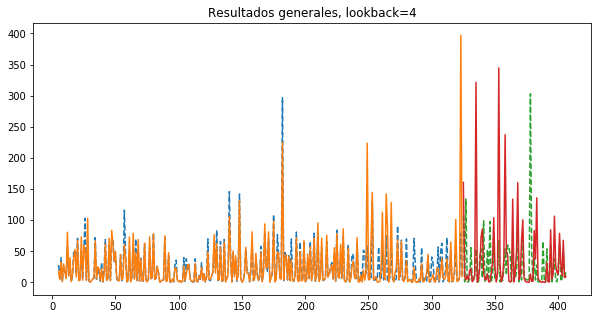

In [617]:
plt.figure(figsize=(10,5))
plt.plot(train_ids_dias, train_npasajeros, '--')
plt.plot(train_ids_dias, train_npasajeros_prediction)
plt.plot(test_ids_dias, test_npasajeros, '--')
plt.plot(test_ids_dias, test_npasajeros_prediction)
plt.title('Resultados generales, lookback=%d' % lookback)
plt.show()

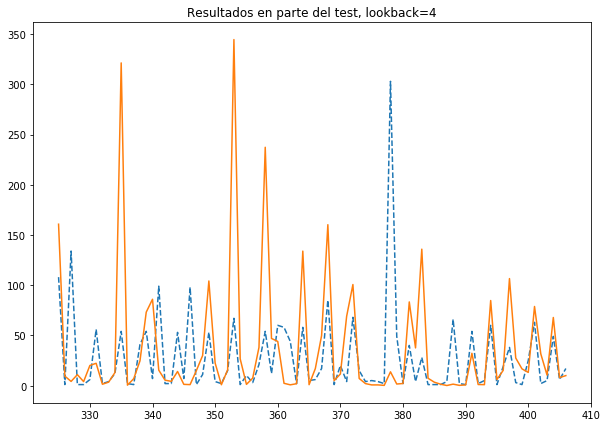

In [618]:
plt.figure(figsize=(10,7))
plt.plot(test_ids_dias, test_npasajeros, '--')
plt.plot(test_ids_dias, test_npasajeros_prediction)
plt.title('Resultados en parte del test, lookback=%d' % lookback)
plt.show()

## 5. Escribir los Resultados

In [619]:
df_training = pd.DataFrame({'linea':int(linea),'tramo':int(tramo_horario),'train_ids_dias':train_ids_dias, 'train_npasajeros': train_npasajeros,'train_pred_npasajeros': train_npasajeros_prediction})
df_test = pd.DataFrame({'linea':int(linea),'tramo':int(tramo_horario),'test_ids_dias':test_ids_dias, 'test_npasajeros': test_npasajeros,'test_pred_npasajeros': test_npasajeros_prediction})

In [620]:
df_training.to_csv('./datosPrediccion/training/data_predict_train_'+linea+'_'+tramo_horario+'.csv',sep=';',index=False)
df_test.to_csv('./datosPrediccion/test/data_predict_test_'+linea+'_'+tramo_horario+'.csv',sep=';',index=False)